In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
#from statsmodels.tsa.stattools import adfuller, kpss
#from statsmodels.tsa.stattools import acf, pacf
#from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_validate
from sklearn.svm import LinearSVR, SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [2]:
gold = pd.read_csv('ouro2.csv')
gold.columns = ['data', 'today_price']
gold['data']= pd.to_datetime(gold.data) #transform data into datetime
#Variação do preço do ouro
# gold['next_week_price'] = gold.today_price.shift(1)
# gold['last_week_price'] = gold.today_price.shift(-1)
# gold['delta'] = gold.today_price - gold.last_week_price
# #gold['s3'] = gold.delta.rolling(window=3).mean()
# #gold['s10'] = gold.delta.rolling(window=10).mean()
# gold['m3'] = gold.today_price.rolling(window=3).mean()
# gold['m5'] = gold.today_price.rolling(window=5).mean()
# gold['m7'] = gold.today_price.rolling(window=7).mean()
# gold['m9'] = gold.today_price.rolling(window=9).mean()
# # gold['m12'] = gold.today_price.rolling(window=12).mean()
# # gold['m14'] = gold.today_price.rolling(window=14).mean()
# # gold['m17'] = gold.today_price.rolling(window=17).mean()
# # gold['m21'] = gold.today_price.rolling(window=21).mean()
# # gold['m28'] = gold.today_price.rolling(window=28).mean()
# gold.dropna(inplace=True)
# print("Número de linhas: {}\nNúmero de colunas: {}".format(gold.shape[0], gold.shape[1]))
# gold.head()

# inverte dataframe para poder fazer as médias móveis com os valores corretos
gold = gold[::-1]

gold['last_week_price'] = gold.today_price.shift(1)
filtro = np.where(gold['today_price'] > gold['last_week_price'], 1, 0)
gold['target_subida'] = filtro
gold['next_week_price'] = gold.today_price.shift(-1)
gold['delta'] = gold.today_price - gold.last_week_price
gold['m3'] = gold.today_price.rolling(window=3).mean()
gold['m5'] = gold.today_price.rolling(window=5).mean()
gold['m7'] = gold.today_price.rolling(window=7).mean()
gold['m9'] = gold.today_price.rolling(window=9).mean()
gold.dropna(inplace=True)

# desinverte o dataframe para não precisar alterar o restante do notebook
gold = gold[::-1]
gold.head()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
1,2021-06-06,1879.6,1892.0,0,1868.0,-12.4,1892.300000,1879.16,1857.014286,1840.133333
2,2021-05-30,1892.0,1905.3,0,1879.6,-13.3,1892.066667,1869.94,1842.771429,1825.377778
3,2021-05-23,1905.3,1878.9,1,1892.0,26.4,1874.733333,1845.50,1827.085714,1807.411111
4,2021-05-16,1878.9,1840.0,1,1905.3,38.9,1850.800000,1820.42,1804.442857,1788.655556
5,2021-09-05,1840.0,1833.5,1,1878.9,6.5,1814.433333,1801.08,1783.214286,1773.866667


In [3]:
gold.tail()

,data,today_price,last_week_price,target_subida,next_week_price,delta,m3,m5,m7,m9
1083,2000-10-09,272.3,273.3,0,271.8,-1.0,274.200000,274.70,274.457143,275.444444
1084,2000-03-09,273.3,277.0,0,272.3,-3.7,274.800000,275.26,275.228571,276.422222
1085,2000-08-27,277.0,274.1,1,273.3,2.9,275.966667,275.12,276.200000,277.522222
1086,2000-08-20,274.1,276.8,0,277.0,-2.7,275.333333,275.26,276.785714,278.977778
1087,2000-08-13,276.8,275.1,1,274.1,1.7,274.833333,276.46,278.085714,279.933333


### Normal series

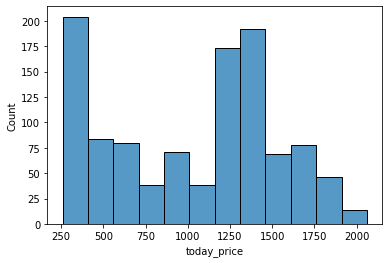

In [4]:
sns.histplot(gold.today_price)

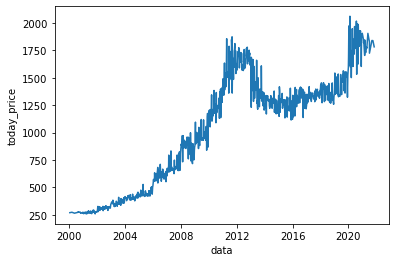

In [5]:
#print timeline graph
sns.lineplot(x=gold.data,y=gold.today_price)
#sns.lineplot(x=gold.data,y=gold.m7)
#sns.lineplot(x=gold.data,y=gold.m14)
#sns.lineplot(x=gold.data,y=gold.m21)

## Conjunto de treinamento

In [6]:
y_test = gold.next_week_price.tail(100) #Consideramos como treinamento os 100 ultimos dias
X_test = gold.tail(100).drop(['data','today_price','next_week_price'],axis=1)
X_train = gold.head(-100).drop(['data','today_price','next_week_price'],axis=1)
print('Conjunto y de teste')
print("Número de linhas: {}".format(y_test.shape[0]))
y_test.head()

Conjunto y de teste
Número de linhas: 100


988    323.9
989    315.6
990    310.9
991    313.5
992    324.6
Name: next_week_price, dtype: float64

In [7]:
X_train

,last_week_price,target_subida,delta,m3,m5,m7,m9
1,1892.0,0,-12.4,1892.300000,1879.16,1857.014286,1840.133333
2,1905.3,0,-13.3,1892.066667,1869.94,1842.771429,1825.377778
3,1878.9,1,26.4,1874.733333,1845.50,1827.085714,1807.411111
4,1840.0,1,38.9,1850.800000,1820.42,1804.442857,1788.655556
5,1833.5,1,6.5,1814.433333,1801.08,1783.214286,1773.866667
...,...,...,...,...,...,...,...
983,314.2,0,-0.5,311.633333,312.44,312.671429,314.088889
984,307.0,1,7.2,308.200000,312.82,312.642857,314.688889
985,303.4,1,3.6,311.433333,312.16,314.128571,315.844444
986,323.9,0,-20.5,314.300000,313.46,315.857143,318.011111


In [8]:
y_train = gold.next_week_price.head(-100)
print('Conjunto y de treino')
print("Número de linhas: {}".format(y_train.shape[0]))
y_train.head()

Conjunto y de treino
Número de linhas: 987


1    1868.0
2    1879.6
3    1892.0
4    1905.3
5    1878.9
Name: next_week_price, dtype: float64

## Baseline

In [9]:
baseline = X_test.query('delta > 0')
acertos_bl = baseline.shape[0]
print("Acertos: {}".format(acertos_bl))

Acertos: 51


# Com delta

### Definindo os conjuntos de entrada para treino e teste

In [10]:
X_test = gold.filter(['delta','m3','m5','m7'],axis=1).tail(100)
print('Conjunto X de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test.shape[0], X_test.shape[1]))
X_test.head()

Conjunto X de teste
Número de linhas: 100
Número de colunas: 4


,delta,m3,m5,m7
988,4.7,313.333333,316.74,319.257143
989,-2.6,316.333333,318.54,319.942857
990,-11.1,319.066667,321.66,319.900000
991,5.5,322.766667,323.04,319.542857
992,-5.5,323.400000,320.24,317.771429


In [11]:
X_train = gold.filter(['delta','m3','m5','m7'],axis=1).head(-100)
print('Conjunto X de treino')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train.shape[0], X_train.shape[1]))
X_train.head()

Conjunto X de treino
Número de linhas: 987
Número de colunas: 4


,delta,m3,m5,m7
1,-12.4,1892.300000,1879.16,1857.014286
2,-13.3,1892.066667,1869.94,1842.771429
3,26.4,1874.733333,1845.50,1827.085714
4,38.9,1850.800000,1820.42,1804.442857
5,6.5,1814.433333,1801.08,1783.214286


## Linear Regressor

In [12]:
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.coef_[2], linear.coef_[3], linear.intercept_))

Linear Regression model
Gold Week Price (y) = 0.57 * Delta (x1) + 1.37 * 3 Days Moving Average (x2) + -0.58 * 5 Days Moving Average (x3) + 0.21 * 7 Days Moving Average (x4) + 4.16 (constant)


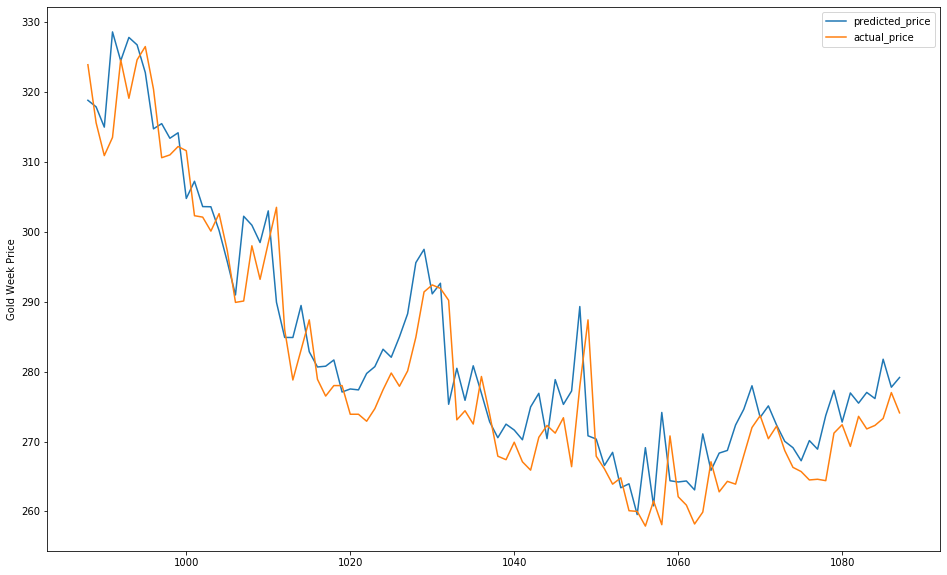

RMSE: 38.29203784329926


In [13]:
predicted_price = linear.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [14]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [15]:
r2_score = linear.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

88.12

In [16]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 43


## Ridge

In [17]:
alpha_list = 10**(np.random.uniform(-3, 3, 50))
final_r2 = np.NINF
for alpha_value in alpha_list:
    ridge = Ridge(alpha=alpha_value).fit(X_train, y_train)
    predicted_price = ridge.predict(X_test)
    r2_score = ridge.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_alpha = alpha_value
        final_coef0 = ridge.coef_[0]
        final_coef1 = ridge.coef_[1]
        final_coef2 = ridge.coef_[2]
        final_coef3 = ridge.coef_[3]
        final_intercept = ridge.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Melhor alpha = {}".format(final_alpha))
print("Linear Regression model with Ridge (l2) regularization")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = 0.881229416930936
Melhor alpha = 848.9555624646518
Linear Regression model with Ridge (l2) regularization
Gold Week Price (y) = 0.57 * Delta (x1) + 1.35 * 3 Days Moving Average (x2) + -0.54 * 5 Days Moving Average (x3) + 0.19 * 7 Days Moving Average (x4) + 4.17 (constant)


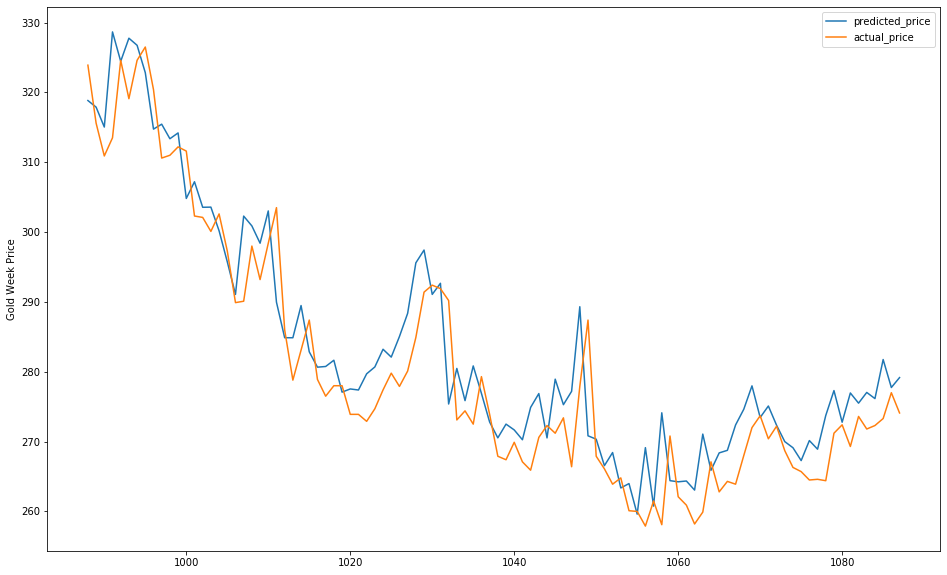

RMSE: 38.28634772125506


In [18]:
ridge = Ridge(alpha=final_alpha).fit(X_train, y_train)
predicted_price = ridge.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [19]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [20]:
r2_score = ridge.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

88.12

In [21]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 42


## Lasso

In [22]:
alpha_list = 10**(np.random.uniform(-3, 3, 50))
final_r2 = np.NINF
for alpha_value in alpha_list:
    lasso = Lasso(alpha=alpha_value, max_iter=10000).fit(X_train, y_train)
    predicted_price = lasso.predict(X_test)
    r2_score = lasso.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_alpha = alpha_value
        final_coef0 = lasso.coef_[0]
        final_coef1 = lasso.coef_[1]
        final_coef2 = lasso.coef_[2]
        final_coef3 = lasso.coef_[3]
        final_intercept = lasso.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Melhor alpha = {}".format(final_alpha))
print("Lasso (l1) regularization")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = 0.8813786920871847
Melhor alpha = 2.2647332825350466
Lasso (l1) regularization
Gold Week Price (y) = 0.57 * Delta (x1) + 1.29 * 3 Days Moving Average (x2) + -0.41 * 5 Days Moving Average (x3) + 0.11 * 7 Days Moving Average (x4) + 4.19 (constant)


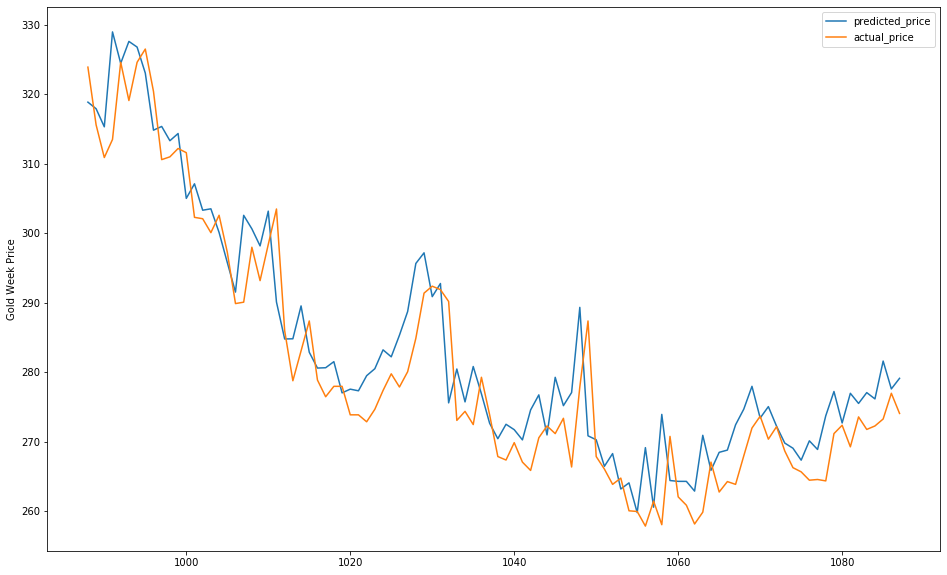

RMSE: 38.23822805735682


In [23]:
lasso = Lasso(alpha=final_alpha, max_iter=10000).fit(X_train, y_train)
predicted_price = lasso.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()
rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [24]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [25]:
r2_score = lasso.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

88.14

In [26]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 42


## Random Forest Regressor

In [27]:
n_estimators_list = [25, 50, 75]
final_r2 = np.NINF
for n_estimators_value in n_estimators_list:
    rf = RandomForestRegressor(n_estimators=n_estimators_value, max_features=2).fit(X_train, y_train)
    predicted_price = rf.predict(X_test)
    r2_score = rf.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_n_estimators = n_estimators_value    
print("Melhor R2 = {}".format(final_r2))
print("Valor de estimadores = {}".format(final_n_estimators))

Melhor R2 = -3.5060458690208174
Valor de estimadores = 25


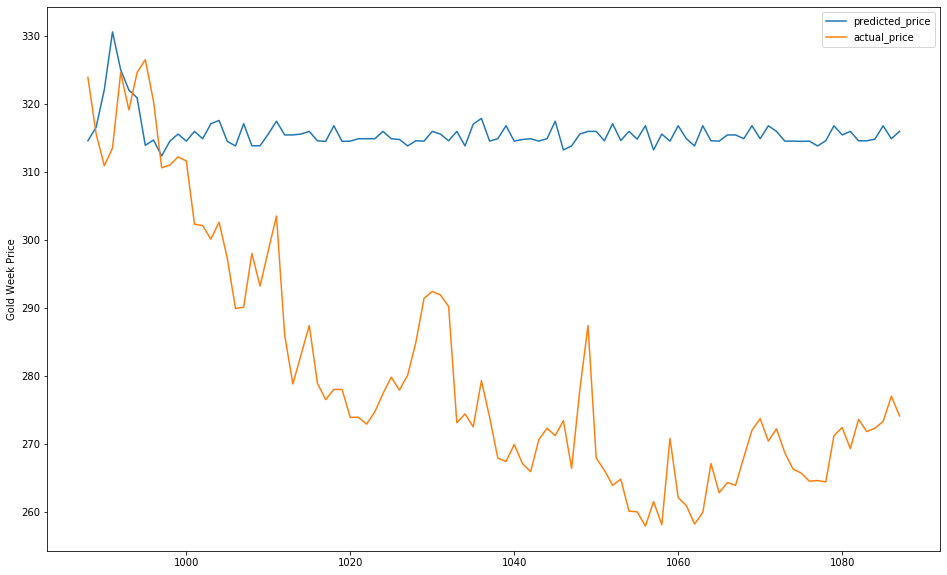

RMSE: 1513.6837639999906


In [28]:
rf = RandomForestRegressor(n_estimators=final_n_estimators).fit(X_train, y_train)
predicted_price = rf.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [29]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [30]:
r2_score = rf.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

-369.57

In [31]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 43


## Linear SVM Regressor

In [32]:
epsilon_list = [0.1, 0.3]
C_list = 2**(np.random.uniform(-5, 15, 10))
final_r2 = np.NINF
for C_value in C_list:
    epsilon_value = random.choice(epsilon_list)
    lsvmr = LinearSVR(epsilon = epsilon_value, C = C_value, max_iter = 10000).fit(X_train, y_train)
    predicted_price = lsvmr.predict(X_test)
    r2_score = lsvmr.score(X_test, y_test)
    if r2_score > final_r2:
        final_r2 = r2_score
        final_epsilon = epsilon_value
        final_C = C_value
        final_coef0 = lsvmr.coef_[0]
        final_coef1 = lsvmr.coef_[1]
        final_coef2 = lsvmr.coef_[2]
        final_coef3 = lsvmr.coef_[3]
        final_intercept = lsvmr.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Valor do epsilon = {}".format(final_epsilon))
print("Valor do C = {}".format(final_C))
print("Linear SVM Regressor model")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = 0.9077863045324193
Valor do epsilon = 0.1
Valor do C = 0.03216396064133571
Linear SVM Regressor model
Gold Week Price (y) = 0.63 * Delta (x1) + 1.45 * 3 Days Moving Average (x2) + -0.67 * 5 Days Moving Average (x3) + 0.22 * 7 Days Moving Average (x4) + 1.03 (constant)


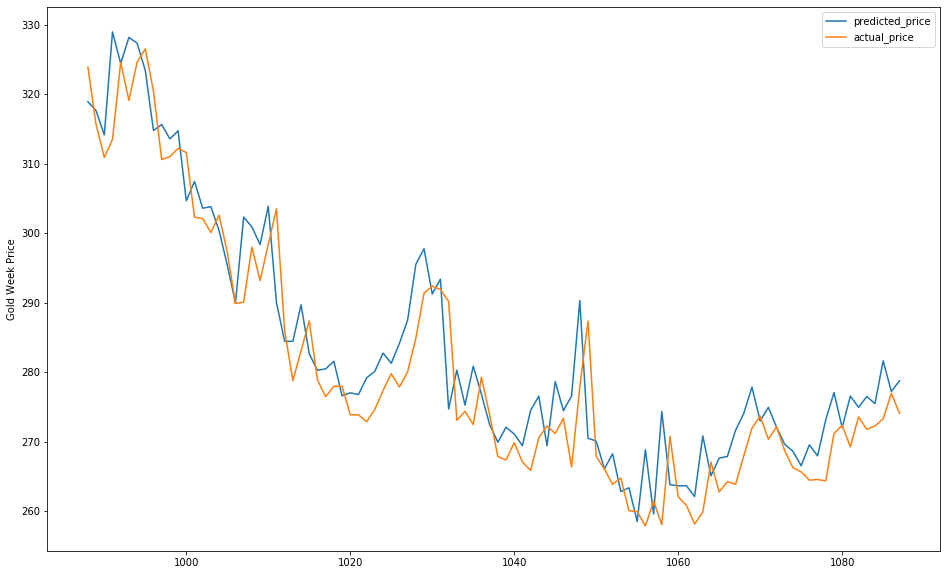

RMSE: 37.2508656852754


In [33]:
lsvmr = LinearSVR(epsilon = final_epsilon, C = final_C, max_iter = 10000).fit(X_train, y_train)
predicted_price = lsvmr.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [34]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [35]:
r2_score = lsvmr.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

88.44

In [36]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 42


## RBF SVM Regressor

In [37]:
epsilon_list = [0.1, 0.3]
C_list = 2**(np.random.uniform(-5, 15, 10))
gamma_list = 2**(np.random.uniform(-9, 3, 10))
final_r2 = np.NINF
for C_value in C_list:
    epsilon_value = random.choice(epsilon_list)
    gamma_value = random.choice(gamma_list)
    svr = SVR(gamma = gamma_value, epsilon = epsilon_value, C = C_value, kernel='rbf').fit(X_train, y_train)
    predicted_price = svr.predict(X_test)
    r2_score = svr.score(X_test, y_test)    
    if r2_score > final_r2:
        final_r2 = r2_score
        final_epsilon = epsilon_value
        final_C = C_value
        final_gamma = gamma_value
        final_coef0 = lsvmr.coef_[0]
        final_coef1 = lsvmr.coef_[1]
        final_coef2 = lsvmr.coef_[2]
        final_coef3 = lsvmr.coef_[3]
        final_intercept = lsvmr.intercept_
print("Resultado da busca por hiperparâmetros:")
print("Melhor R2 = {}".format(final_r2))
print("Valor do epsilon = {}".format(final_epsilon))
print("Valor do C = {}".format(final_C))
print("Valor do gamma = {}".format(final_gamma))
print("RBF SVM Regressor model")
print("Gold Week Price (y) = %.2f * Delta (x1) \
+ %.2f * 3 Days Moving Average (x2) \
+ %.2f * 5 Days Moving Average (x3) \
+ %.2f * 7 Days Moving Average (x4) \
+ %.2f (constant)" % (final_coef0, final_coef1, final_coef2, final_coef3, final_intercept))

Resultado da busca por hiperparâmetros:
Melhor R2 = -2132.889802299708
Valor do epsilon = 0.3
Valor do C = 29715.360678209723
Valor do gamma = 5.079896353319244
RBF SVM Regressor model
Gold Week Price (y) = 0.63 * Delta (x1) + 1.45 * 3 Days Moving Average (x2) + -0.67 * 5 Days Moving Average (x3) + 0.23 * 7 Days Moving Average (x4) + 1.03 (constant)


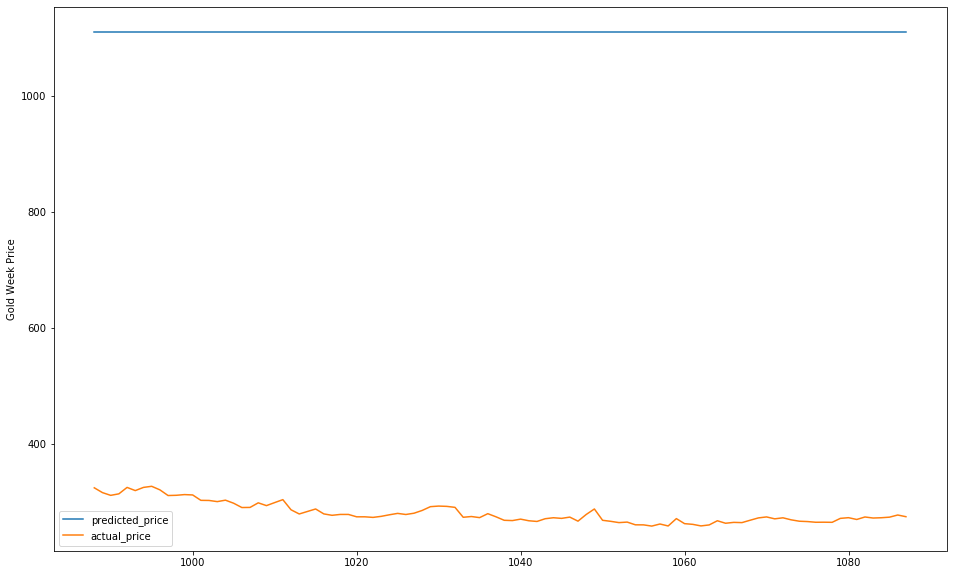

RMSE: 687871.0608179786


In [38]:
svr = SVR(gamma = final_gamma, epsilon = final_epsilon, C = final_C, kernel='rbf').fit(X_train, y_train)
predicted_price = svr.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

rmse = mean_squared_error(y_test, predicted_price)
print("RMSE:", rmse)

In [39]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [40]:
r2_score = svr.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

-213288.98

In [41]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 2


# Sem delta

In [42]:
X_test = gold.filter(['m3','m5','m7'],axis=1).tail(100)
print('Conjunto X de teste')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_test.shape[0], X_test.shape[1]))
X_test.head()

Conjunto X de teste
Número de linhas: 100
Número de colunas: 3


,m3,m5,m7
988,313.333333,316.74,319.257143
989,316.333333,318.54,319.942857
990,319.066667,321.66,319.900000
991,322.766667,323.04,319.542857
992,323.400000,320.24,317.771429


In [43]:
X_train = gold.filter(['m3','m5','m7'],axis=1).head(-100)
print('Conjunto X de treino')
print("Número de linhas: {}\nNúmero de colunas: {}".format(X_train.shape[0], X_train.shape[1]))
X_train.head()

Conjunto X de treino
Número de linhas: 987
Número de colunas: 3


,m3,m5,m7
1,1892.300000,1879.16,1857.014286
2,1892.066667,1869.94,1842.771429
3,1874.733333,1845.50,1827.085714
4,1850.800000,1820.42,1804.442857
5,1814.433333,1801.08,1783.214286


## Linear Regressor

In [44]:
cross_val = cross_validate(
    LinearRegression(),
    X_train,
    y_train,
    scoring=('neg_root_mean_squared_error')
)
rmse_medio =  np.sqrt(np.mean(np.absolute(cross_val['test_score'])))
print("RMSE = {}".format(rmse_medio))

RMSE = 5.675574184437945


In [45]:
linear = LinearRegression().fit(X_train, y_train)
print("Linear Regression model")
print("Gold Week Price (y) = %.2f * 3 Days Moving Average (x1) \
+ %.2f * 5 Days Moving Average (x2) \
+ %.2f * 7 Days Moving Average (x3) \
+ %.2f (constant)" % (linear.coef_[0], linear.coef_[1], linear.coef_[2], linear.intercept_))

Linear Regression model
Gold Week Price (y) = 1.67 * 3 Days Moving Average (x1) + -0.98 * 5 Days Moving Average (x2) + 0.31 * 7 Days Moving Average (x3) + 5.39 (constant)


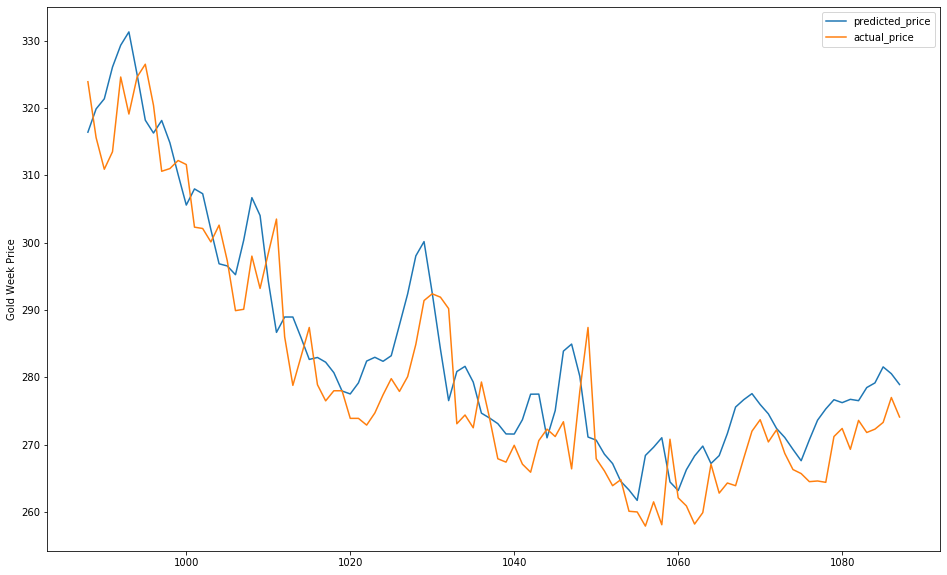

In [46]:
predicted_price = linear.predict(X_test)
d = {'actual_price': y_test,'predicted_price': predicted_price}
df = pd.DataFrame(data=d)
df['actual_var'] = df.actual_price.shift(1) - df.actual_price
df['actual_var_sign'] = np.sign(df.actual_var)
df['predicted_var'] = df.predicted_price.shift(1) - df.predicted_price
df['predicted_var_sign'] = df.predicted_var/abs(df.predicted_var)
df['correct_prediction'] = np.equal(df.actual_var_sign, df.predicted_var_sign)
predicted_price = pd.DataFrame(
    predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(16, 10))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold Week Price")
plt.show()

In [47]:
df.head(30)
print("Número de linhas: {}".format(df.shape[0]))

Número de linhas: 100


In [48]:
r2_score = linear.score(X_test, y_test)*100
float("{0:.2f}".format(r2_score))

83.35

In [49]:
res = df.query('correct_prediction == True')
acertos = res.shape[0]
print("Acertos: {}".format(acertos))

Acertos: 48
